In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision import models
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}")

Training on: cuda


In [3]:

# transform data
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # 3 channel (R, G, B)
    transforms.Resize(224)  # Resize to 224x224 for ResNet
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # 3 channel (R, G, B)
    transforms.Resize(224)  # Resize to 224x224 for ResNet
])


In [4]:
# load data CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 53.1MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# load model MobileNetV2
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 10)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 123MB/s]


In [6]:
# loss dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# training loop
epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    loss_value = running_loss / len(trainloader)
    train_losses.append(loss_value)
    train_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss_value:.4f}, Accuracy: {accuracy:.2f}%")

Epoch [1/10], Loss: 0.5676, Accuracy: 80.55%
Epoch [2/10], Loss: 0.3741, Accuracy: 87.34%
Epoch [3/10], Loss: 0.3269, Accuracy: 88.88%
Epoch [4/10], Loss: 0.2885, Accuracy: 90.12%
Epoch [5/10], Loss: 0.2642, Accuracy: 91.00%
Epoch [6/10], Loss: 0.2497, Accuracy: 91.28%
Epoch [7/10], Loss: 0.2305, Accuracy: 92.08%
Epoch [8/10], Loss: 0.2138, Accuracy: 92.69%
Epoch [9/10], Loss: 0.2006, Accuracy: 93.05%
Epoch [10/10], Loss: 0.1856, Accuracy: 93.71%


Test Accuracy: 91.27%


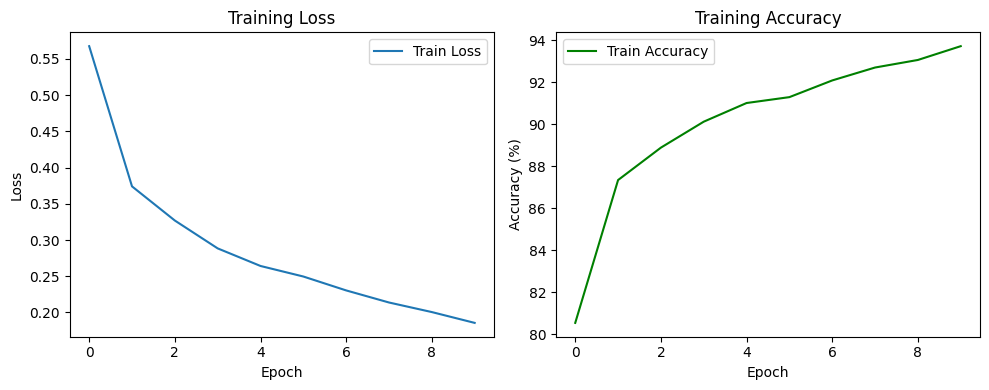

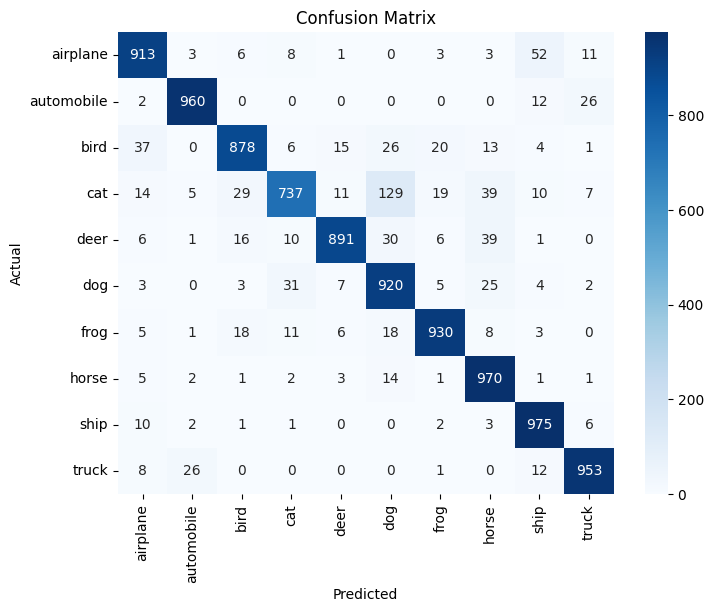

In [8]:
# --- Evaluation ---
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Accuracy
test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# --- Visualize ---

# Plot Loss & Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("training_metrics.png")
plt.show()

# Confusion Matrix
classes = trainset.classes
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

In [11]:
torch.save(model.state_dict(), "/kaggle/working/model.pth")
print("Model saved to model.pth")

✅ Model saved to model.pth
